<a href="https://colab.research.google.com/github/Slrosales/Huesitos/blob/main/C%C3%B3digo/Huesitos_Oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos
## Objetivo General
Desarrollar, a través de la implementación y comprensión de métodos numéricos, un modelo automatizado de Machine Learning que permita la detección de fracturas en imágenes médicas.

## Objetivos específicos

* Crear y consolidar un dataset, denominado "Huesitos", que comprenda 326 imágenes con indicadores de fractura y 300 imágenes sin evidencia de fractura, garantizando una variedad y balance en los datos a procesar.

* Aplicar técnicas de preprocesamiento a las imágenes del dataset con el fin de normalizar y homogeneizar los datos de entrada, mejorando así la eficacia del proceso de entrenamiento del modelo.

* Emplear y comprender en profundidad los métodos numéricos para la extracción de características esenciales de las imágenes, incluyendo técnicas como el Histograma de Intensidades, Gradiente de una imagen, Extracción de características de Hog y el Método de Haralick, entre otros.

* Contrastar y comparar los resultados obtenidos mediante la implementación directa de métodos numéricos con aquellos arrojados por las bibliotecas especializadas, profundizando en la comprensión y adaptabilidad de dichos métodos.

* Diseñar y entrenar un modelo, utilizando CNN de Tensorflow, que sea capaz de clasificar eficientemente las imágenes en dos categorías principales: con fractura y sin fractura.

* Evaluar el desempeño del modelo desarrollado, empleando métricas de validación como el AUC-ROC, para medir la habilidad del modelo de distinguir entre clases en distintos niveles de umbral, y el AUC-PR, que se enfoca en el rendimiento del modelo en la clase positiva, especialmente cuando hay un desbalance en las clases.

* Implementar una interfaz gráfica que permita subir una imagen y ver la interpretación del código de forma dinámica

# Librerias

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install scikit-image
!pip install datasets
!pip install huggingface_hub
!pip show gradio
!pip install --upgrade gradio
!pip install tensorflow
clear_output()

In [ ]:
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import gradio as gr
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy.optimize import minimize
from skimage import img_as_ubyte, color, exposure, morphology, io, filters
from skimage.feature import hog, greycomatrix, greycoprops
from skimage.filters import threshold_otsu
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_curve, auc,
                             precision_recall_curve, roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from datasets import load_dataset, concatenate_datasets, Dataset


# Extraccion de Dataset desde Huuging Face

In [ ]:
dataset = load_dataset('LosHuesitos9-9/Huesitos')
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/626 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/44 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/88 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 626
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 44
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 88
    })
})

In [ ]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [ ]:
dataset['train'][100]

{'image_id': 271,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [350],
  'area': [336],
  'bbox': [[485.0, 326.0, 21.0, 16.0]],
  'category': [2]}}

In [ ]:
dataset['train'][400]

{'image_id': 575,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=420x512>,
 'width': 420,
 'height': 512,
 'objects': {'id': [], 'area': [], 'bbox': [], 'category': []}}

Información sobre la estructura del dataset:

- **ID de la imagen**: Cada entrada tiene un identificador único asociado con la clave `image_id`.
- **URL de la imagen**: Las imágenes están alojadas en línea y se puede acceder a ellas mediante el enlace proporcionado en `image['src']`.
- **Dimensiones de la imagen**: Cada imagen tiene dimensiones especificadas por `width` y `height`.
- **Objetos en la imagen**: Hay objetos en las imágenes (que probablemente sean referencias a fracturas u otras características) que tienen:
  - Su propio **ID**, indicado por la clave `id`.
  - **Área** del objeto, indicada por la clave `area`.
  - **Cuadro delimitador** (`bbox`) que especifica la ubicación y el tamaño del objeto en la imagen.
  - **Categoría** del objeto, indicada por la clave `category`.


In [ ]:
train_data = dataset['train']

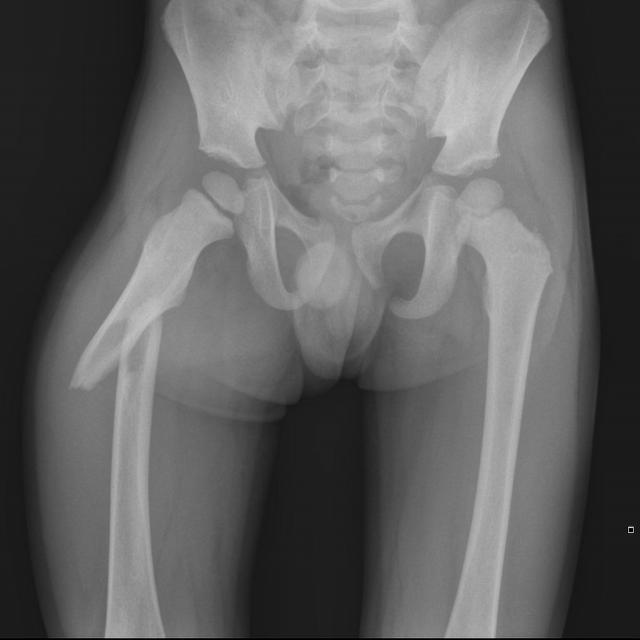

In [ ]:
dataset['train'][200]['image']

# Preprocesamiento

## Escala de grises, normalización, y redimensionar imágenes

In [ ]:
def preprocess_image(pil_image, target_size=(224, 224)):

  # Convertir la imagen a escala de grises si no lo está
  if pil_image.mode != 'L':
      pil_image = pil_image.convert('L')

  # Convertir la imagen PIL a una imagen de OpenCV
  image_cv = np.array(pil_image)
  image_cv = cv2.cvtColor(image_cv, cv2.COLOR_GRAY2BGR)

  # Aplicar CLAHE (contraste, brillo...)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  image_clahe = clahe.apply(cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY))

  # Convertir de nuevo a imagen PIL para redimensionar
  image_resized = Image.fromarray(image_clahe).resize(target_size, Image.Resampling.LANCZOS)

  # Convertir la imagen redimensionada a un numpy array y normalizar a [0,1]
  return np.array(image_resized) / 255.0


In [ ]:
def preprocess_all_images(data, target_size=(224, 224)):
  preprocessed_images = []

  for i, entry in enumerate(data):
    try:
        image_array = preprocess_image(entry['image'], target_size=target_size)
        preprocessed_images.append(image_array)

    except Exception as e:
        print(f"Error processing image at index {i}: {e}")
        preprocessed_images.append(None)

  return preprocessed_images

In [ ]:
all_preprocessed_images = preprocess_all_images(train_data)

### Resultados

In [ ]:
def array_img(array_org, array_pre, num_rows=4, num_cols=4):
  print("Array Original")
  image_or = np.array(array_org)
  print(image_or[:num_rows, :num_cols])
  print()
  print("Array Procesado")
  print(array_pre[:num_rows, :num_cols])

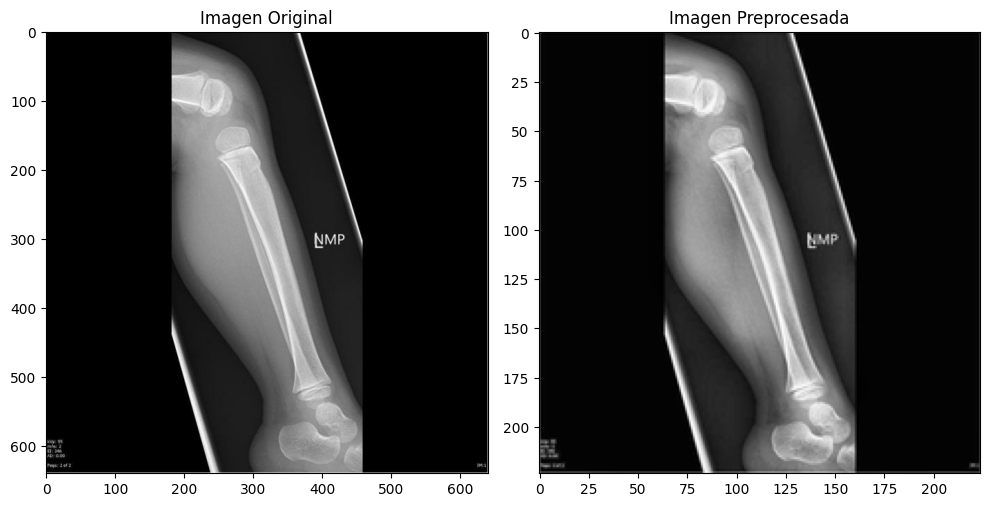

Array Original
[[[227 227 227]
  [145 145 145]
  [160 160 160]
  [147 147 147]]

 [[138 138 138]
  [ 24  24  24]
  [ 19  19  19]
  [  7   7   7]]

 [[162 162 162]
  [ 19  19  19]
  [  4   4   4]
  [  5   5   5]]

 [[154 154 154]
  [  7   7   7]
  [  0   0   0]
  [  7   7   7]]]

Array Procesado
[[0.38823529 0.21568627 0.23137255 0.23529412]
 [0.21960784 0.         0.00392157 0.        ]
 [0.22352941 0.00392157 0.03529412 0.01960784]
 [0.21568627 0.         0.02352941 0.01176471]]


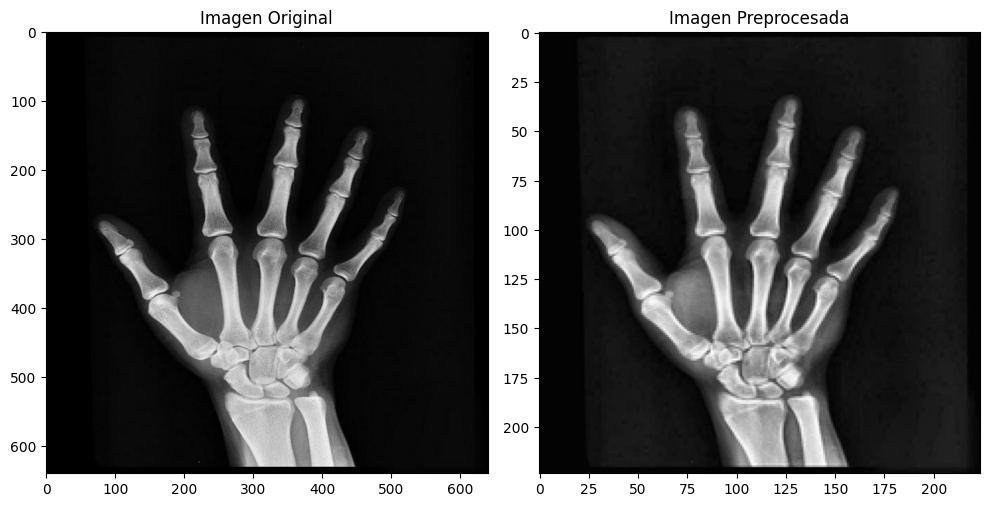

Array Original
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]

Array Procesado
[[0.01176471 0.01176471 0.01176471 0.01176471]
 [0.01176471 0.01176471 0.01176471 0.01176471]
 [0.01176471 0.01176471 0.01176471 0.01176471]
 [0.01176471 0.01176471 0.01176471 0.01176471]]


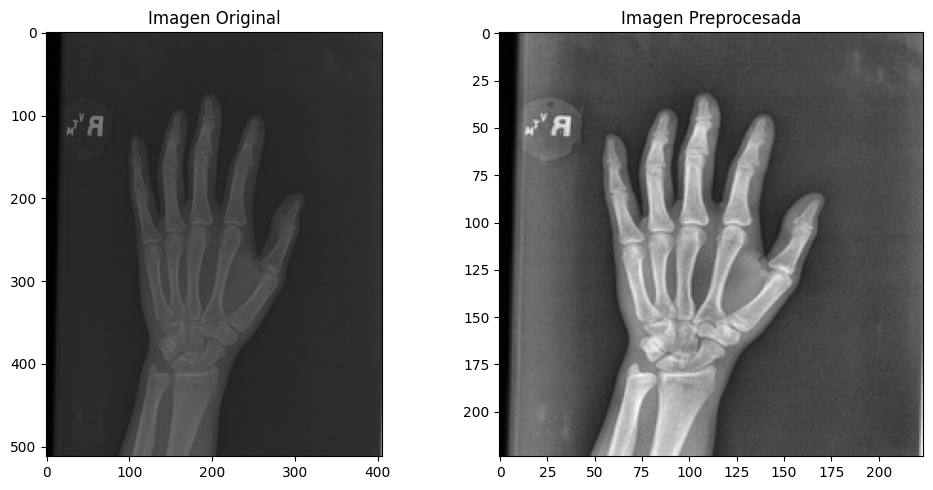

Array Original
[[[2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[2 2 2]
  [2 2 2]
  [1 1 1]
  [2 2 2]]

 [[2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]]]

Array Procesado
[[0.02352941 0.02352941 0.02352941 0.02352941]
 [0.02352941 0.01960784 0.02352941 0.02352941]
 [0.02352941 0.01960784 0.02352941 0.01960784]
 [0.02352941 0.02352941 0.02352941 0.02352941]]


In [ ]:
def display_preprocessed_image(image_or, image_pre, texto1, texto2):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(image_or, cmap=plt.cm.gray)
  plt.title(texto1)

  plt.subplot(1, 2, 2)
  plt.imshow(image_pre, cmap=plt.cm.gray)
  plt.title(texto2)
  plt.tight_layout()
  plt.show()

  array_img(image_or, image_pre)

display_preprocessed_image(dataset['train'][0]['image'], all_preprocessed_images[0], 'Imagen Original', "Imagen Preprocesada")
display_preprocessed_image(dataset['train'][18]['image'], all_preprocessed_images[18], 'Imagen Original', "Imagen Preprocesada")
display_preprocessed_image(dataset['train'][426]['image'], all_preprocessed_images[426], 'Imagen Original', "Imagen Preprocesada")

## Histograma de intensidades

In [ ]:
def extract_features(image_array):
  hist, _ = np.histogram(image_array, bins=256, range=(0, 1))

  hist_normalized = hist / np.sum(hist)

  return hist_normalized

In [ ]:
def display_histogram(hist):
  plt.bar(range(len(hist)), hist)
  plt.xlabel('Valor de intensidad')
  plt.ylabel('Proporción de píxeles')
  plt.title('Histograma de intensidades')
  plt.show()

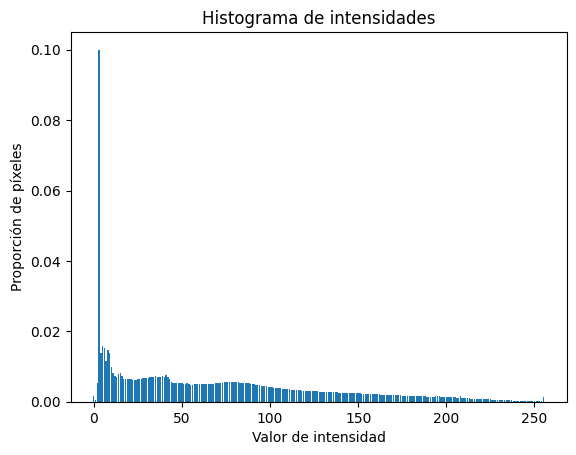

In [ ]:
all_features = [extract_features(image) for image in all_preprocessed_images]
display_histogram(np.mean(all_features, axis=0))

### Resultados

In [ ]:
all_features[620][:20] # Primeros 20 valores

array([1.39508929e-04, 5.97895408e-05, 3.98596939e-05, 0.00000000e+00,
       5.97895408e-05, 7.37404337e-04, 5.77965561e-03, 1.00127551e-01,
       1.91685268e-01, 2.79635682e-01, 2.15282207e-01, 6.48317921e-02,
       5.79958546e-03, 5.97895408e-04, 3.78667092e-04, 4.98246173e-04,
       2.59088010e-04, 1.59438776e-04, 2.19228316e-04, 2.19228316e-04])

# Extracción de Características



## Gradiente

### Otsu

In [ ]:
def metodo_otsu(magnitude):
  histogram, bins = np.histogram(magnitude.flatten(), bins=256, range=[0,256])
  bins = bins[0:-1] # bin_edges tiene un elemento más que el array hist
  graficar_umbral(histogram, bins)

  probabilidades = histogram / np.sum(histogram)
  media_global = np.sum(bins * probabilidades)

  sigma_b_cuadrada_max = 0
  umbral_optimo = 0

  for t in range(len(bins)):
      P1 = np.sum(probabilidades[:t])
      P2 = np.sum(probabilidades[t:])
      if P1 == 0 or P2 == 0:
          continue
      M1 = np.sum(bins[:t] * probabilidades[:t]) / P1
      M2 = np.sum(bins[t:] * probabilidades[t:]) / P2
      sigma_b_cuadrada = P1 * (M1 - media_global)**2 + P2 * (M2 - media_global)**2
      if sigma_b_cuadrada > sigma_b_cuadrada_max:
          sigma_b_cuadrada_max = sigma_b_cuadrada
          umbral_optimo = bins[t]

  # Comparacion entre librerias
  umbral_libreria = threshold_otsu(magnitude)
  print("Umbral (manual):", umbral_optimo)
  print("Umbral (skimage):", umbral_libreria)
  print()
  e_abs = abs(umbral_optimo - umbral_libreria)
  print("Error absuluto del umbral:", e_abs )
  print("Error relativo del umbral:", (e_abs/umbral_libreria)*100, "%")

  return umbral_optimo

In [ ]:
def graficar_umbral(histogram, bins):
  plt.figure()
  plt.plot(bins, histogram)
  plt.title('Histograma de la Magnitud del Gradiente')
  plt.xlabel('Valor del Gradiente')
  plt.ylabel('Frecuencia')
  plt.show()

### Gradiente

In [ ]:
def sigma_adaptativo(imagen, factor=0.15):
  varianza = np.var(imagen)

  # Calcular sigma como una función logarítmica de la varianza para evitar que sea demasiado grande
  sigma = np.log1p(varianza) * factor

  return sigma

In [ ]:
def graficar_gradiente(gray_image, Gx, Gy,normalized_magnitude, binary_image, bordes_resaltados):
  plt.figure(figsize=(16, 10))

  plt.subplot(2, 3, 1)
  plt.title('imagen Preprocesada')
  plt.imshow(gray_image, cmap='gray')
  plt.axis('off')

  plt.subplot(2, 3, 2)
  plt.title('Gx')
  plt.imshow(Gx, cmap='gray')
  plt.axis('off')

  plt.subplot(2, 3, 3)
  plt.title('Gy')
  plt.imshow(Gy, cmap='gray')
  plt.axis('off')

  plt.subplot(2, 3, 4)
  plt.title('Magnitud')
  plt.imshow(normalized_magnitude, cmap='gray')
  plt.axis('off')

  plt.subplot(2, 3, 5)
  plt.title('Imagen Binaria')
  plt.imshow(binary_image, cmap='gray')
  plt.axis('off')

  plt.subplot(2, 3, 6)
  plt.title('Bordes Resaltados')
  plt.imshow(bordes_resaltados, cmap='gray')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def central_difference(image):
  # Convertir la imagen a float64 para evitar desbordamiento durante la resta
  image = image.astype(np.float64)

  height, width = image.shape

  Gx = np.zeros((height, width), dtype=np.float64)
  Gy = np.zeros((height, width), dtype=np.float64)

  # Iterar sobre la imagen evitando los bordes
  for i in range(1, height-1):
      for j in range(1, width-1):

        # Diferencias centrales
        Gx[i, j] = (image[i, j+1] - image[i, j-1]) / 2
        Gy[i, j] = (image[i+1, j] - image[i-1, j]) / 2


  return Gx, Gy

In [ ]:
def gradiente(sample_image):
  gray_image = img_as_ubyte(sample_image)

  Gx, Gy = central_difference(gray_image)

  magnitud = np.sqrt(Gx**2 + Gy**2)

  angle = np.arctan2(Gy, Gx)

  T =  metodo_otsu(magnitud)  # Umbral

  # Binarizar la imagen basada en la magnitud del gradiente
  binary_image = (magnitud > T).astype(np.uint8) * 255

  # Normalizar la magnitud para la visualización
  normalized_magnitud = (magnitud / magnitud.max()) * 255
  normalized_magnitud = normalized_magnitud.astype(np.uint8)

  # Calcular el ángulo del gradiente y escalarlo para la visualización
  angle_degrees = np.degrees(angle)
  angle_normalized = (angle_degrees + 180) / 360  # Normalizar los ángulos entre 0 y 1
  angle_for_display = (angle_normalized * 255).astype(np.uint8)

  # Aplicar filtro gaussiano para suavizado
  sigma = sigma_adaptativo(sample_image)
  radiografia_suavizada = gaussian_filter(sample_image, sigma=sigma)

  binarizado_gradiente = magnitud > T

  # Restar la imagen binarizada de bordes de la radiografía suavizada
  bordes_resaltados = radiografia_suavizada - binarizado_gradiente


  graficar_gradiente(gray_image, Gx, Gy,normalized_magnitud, binary_image, bordes_resaltados)



### Resultado

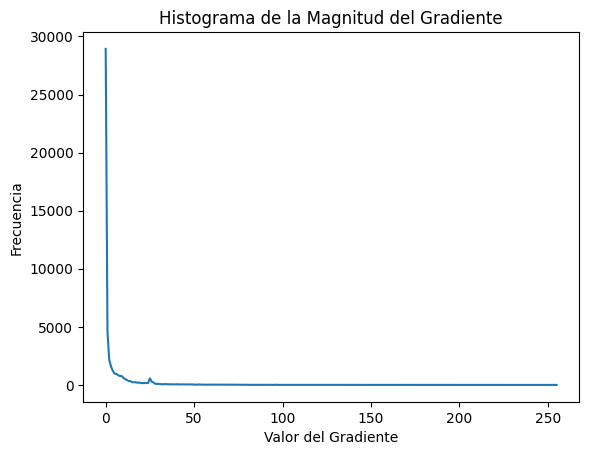

Umbral (manual): 33.0
Umbral (skimage): 32.298604091207096

Error absuluto del umbral: 0.7013959087929038
Error relativo del umbral: 2.1715982115271983 %


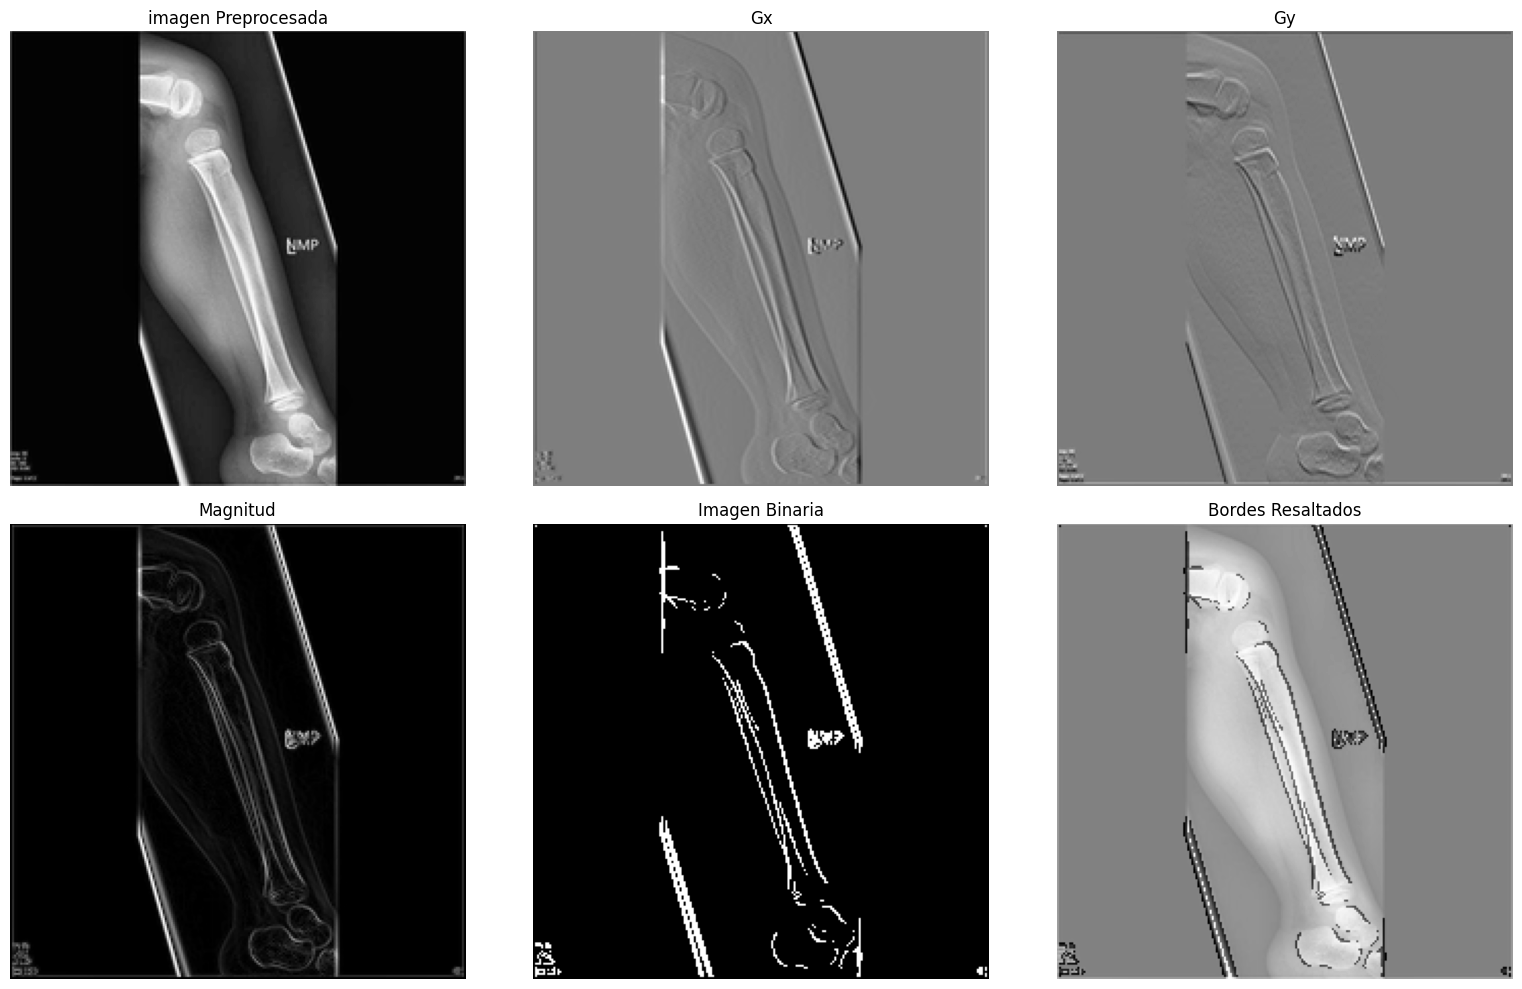

In [ ]:
sample_image = all_preprocessed_images[0]
gradiente(sample_image)

## Visualización HOG

### Libreria

In [ ]:
# Imagenes preprocesadas
features = all_features

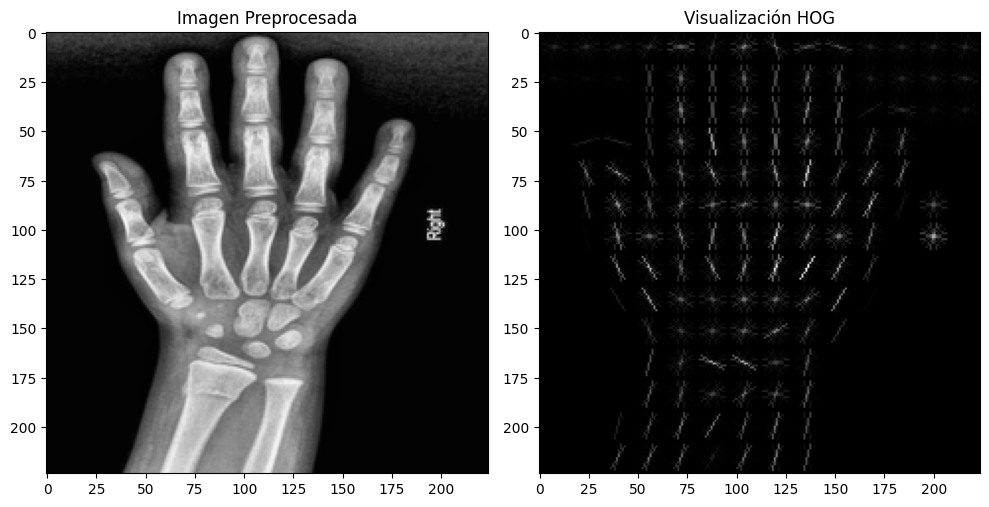

Array Original
[[0.2627451  0.28235294 0.26666667 0.25882353]
 [0.2627451  0.2627451  0.23921569 0.23529412]
 [0.21960784 0.24705882 0.23137255 0.22745098]
 [0.26666667 0.25490196 0.23137255 0.2745098 ]]

Array Procesado
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Suponiendo que all_preprocessed_images ya está definido y contiene las imágenes preprocesadas
image_pre = all_preprocessed_images[4]
image_hog = preprocess_image(dataset['train'][4]['image'])

# Extraer características HOG y obtener la imagen HOG
fd, hog_image = hog(image_hog, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

# Mejorar el contraste de la imagen HOG para la visualización
hog_image2 = exposure.rescale_intensity(hog_image, (0, 10))

# Visualizar
display_preprocessed_image(image_pre, hog_image2, "Imagen Preprocesada", "Visualización HOG")
plt.figure(figsize=(10, 5))

### Manual HOG

In [ ]:
def compute_gradient(gray_image):
    Gx, Gy = central_difference(gray_image)
    magnitude = np.sqrt(Gx**2 + Gy**2)
    angle = np.arctan2(Gy, Gx)

    return magnitude, angle

def create_cells(magnitude, angle, cell_size):
    height, width = magnitude.shape
    # Calcular el numero de celdas en ambas dimensiones
    num_cells_height = height // cell_size
    num_cells_width = width // cell_size
    cells = []

    for i in range(num_cells_height):
        for j in range(num_cells_width):
            # Definir las cordenadas de la esquina superio izquierda
            cell_start_x = j * cell_size
            cell_start_y = i * cell_size

            #  Extraer las partes de magnitud y angulo correspondiente a cada celda
            cell_magnitude = magnitude[cell_start_y:cell_start_y+cell_size, cell_start_x:cell_start_x+cell_size]
            cell_angle = angle[cell_start_y:cell_start_y+cell_size, cell_start_x:cell_start_x+cell_size]
            cells.append((cell_magnitude, cell_angle))

    return cells

def compute_histogram(cell_magnitude, cell_angle, num_bins=9):
    histogram = np.zeros(num_bins)

    cell_angle = np.degrees(cell_angle) % 180
    bin_indices = (cell_angle / (180 / num_bins)).astype(int)

    # Acumular las magnitudes en sus contenedores correspondientes
    for i in range(num_bins):
        histogram[i] = np.sum(cell_magnitude[bin_indices == i])

    return histogram

def block_normalization(histograms, block_size):
    normalized_histograms = []

    for i in range(0, len(histograms), block_size):
        block = histograms[i:i+block_size]

        # Aplicar normalizacion L2, se suma un pequeño valor para evitar division por 0
        norm_factor = np.sqrt(np.sum(np.square(block)) + 1e-6)
        normalized_block = block / norm_factor
        normalized_histograms.extend(normalized_block)

    return normalized_histograms

### Resultado

In [ ]:
# Ejemplo de uso
image_hog = all_preprocessed_images[0]

In [ ]:
brightness_threshold = 0.2
brightest_mask = (image_hog > brightness_threshold)
noise_out = np.zeros_like(image_hog)
noise_out[brightest_mask] = image_hog[brightest_mask]

cell_size = 8
block_size = 2
magnitude, angle = compute_gradient(noise_out)
height = magnitude.shape[0]

cells = create_cells(magnitude, angle, cell_size)
histograms = [compute_histogram(cell_magnitude, cell_angle) for (cell_magnitude, cell_angle) in cells]
normalized_blocks = block_normalization(histograms, block_size )
hog_descriptor = np.concatenate(normalized_blocks)

<ipython-input-31-2af9ad7f7afb>:18: RuntimeWarning: invalid value encountered in divide
  ave_grad /= hist_counter


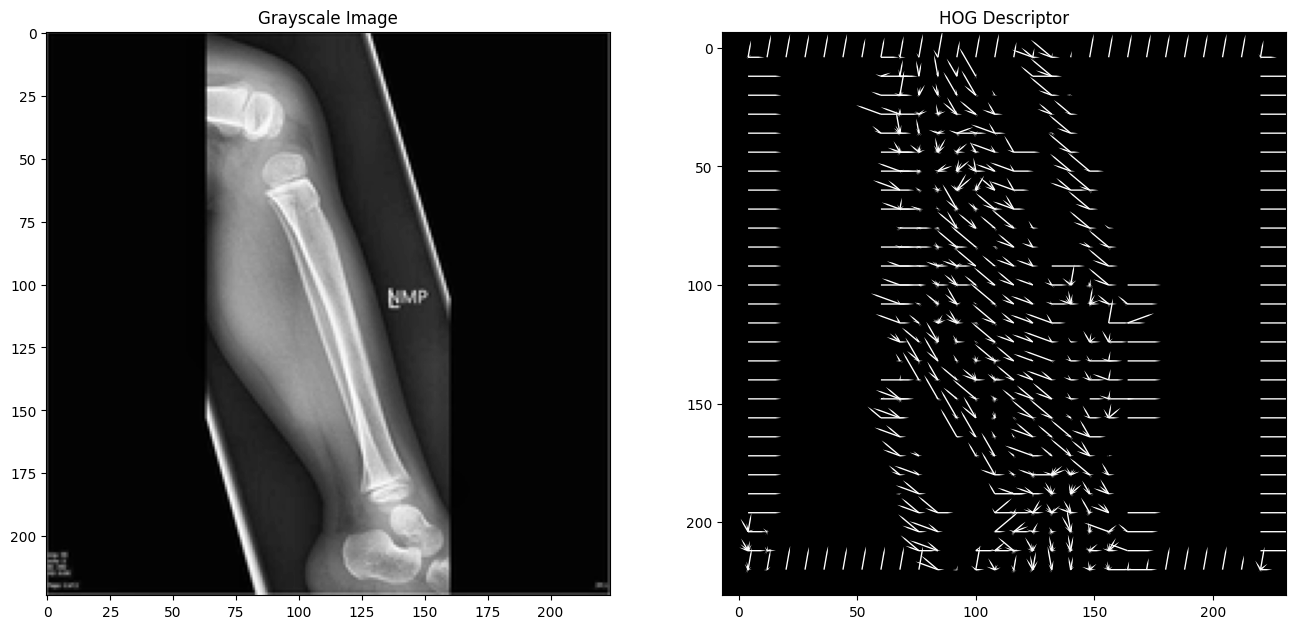

In [ ]:
# Graficar vector unidimensional como imagen
cell_rows,cell_cols = image_hog.shape[0] // 8, image_hog.shape[1] // 8

block_rows, block_cols, num_bins =  1, 1, 9
hog_descriptor_reshaped = hog_descriptor.reshape(cell_rows, cell_cols, block_rows, block_cols, num_bins).transpose((1, 0, 2, 3, 4))


ave_grad = np.zeros((cell_rows + 1, cell_cols + 1, num_bins))
hist_counter = np.zeros((cell_rows + 1, cell_cols + 1, 1))

# Calcula la gradiente promedio y el recuento de histogram por celdas
for i in range(block_rows):
    for j in range(block_cols):
        ave_grad[i:cell_rows + i, j:cell_cols + j] += hog_descriptor_reshaped[:, :, i, j, :]
        hist_counter[i:cell_rows + i, j:cell_cols + j] += 1


ave_grad /= hist_counter
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]
deg = np.linspace(0, np.pi, num_bins, endpoint=False)

# Cada celda tendrá un histograma con num_bins. Para cada celda, se representará cada bin como un vector.
# Crear arrays que almacenarán todas las posiciones y componentes de los vectores.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

counter = 0
cell_size = ( 8,  8)

# Calcular las posiciones y magnitudes de los vectores a partir del arreglo de gradiente promedio
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
            V[counter] = ave_grad[i, j, k] * np.sin(deg[k])
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
            counter += 1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set(title='Grayscale Image')
ax1.imshow(image_hog, cmap='gray')
# Se aplica un threshold para obviar magnitudes despreciables
threshold = 0.05
filtered_indices = np.where(np.sqrt(U**2 + V**2) > threshold)
ax2.set(title='HOG Descriptor')
ax2.quiver(X[filtered_indices], Y[filtered_indices], U[filtered_indices], V[filtered_indices], color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)

ax2.invert_yaxis()
ax2.set_aspect('equal')
ax2.set_facecolor('black')
plt.show()

## Método Haralick

In [ ]:
sample_image = all_preprocessed_images[426]
image_gray = img_as_ubyte(sample_image)

### Con libreria

In [ ]:
def haralick_features(image_array):
  # Calcular la matriz GLCM
  glcm = greycomatrix(image_gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)

  # Características Haralick
  contrast = greycoprops(glcm, prop='contrast')
  homogeneity = greycoprops(glcm, prop='homogeneity')
  correlation = greycoprops(glcm, prop='correlation')
  energy = greycoprops(glcm, prop='ASM')  # ASM (Second Moment) es equivalente a la energía

  return np.array([contrast, homogeneity, correlation, energy]).flatten()

features = haralick_features(image_gray)


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [ ]:
# Valores de características de skimage
skimage_features = features.copy()

# Calcular promedios
mean_contrast_skimage = np.mean(skimage_features[:4])
mean_homogeneity_skimage = np.mean(skimage_features[4:8])
mean_correlation_skimage = np.mean(skimage_features[8:12])
mean_energy_skimage = np.mean(skimage_features[12:16])

### Sin Libreria

In [ ]:
# Funciones para calcular las propiedades GLCM
def f_glcm(image, d, angle):

  d = np.array(d).item()
  angle = np.array(angle).item()

  size = image.shape[0]

  glcm = np.zeros((256, 256))

  # Convertir el ángulo a radianes
  angle_rad = np.radians(angle)
  dx = int(round(d * np.sin(angle_rad)))
  dy = int(round(d * np.cos(angle_rad)))

  for i in range(size):
      for j in range(size):
          # Comprobar si los índices + desplazamientos están dentro de las dimensiones de la imagen
          if  0 <= i + dx < size and 0 <= j + dy < size:
              row = image[i, j]
              col = image[i + dx, j + dy]
              glcm[row, col] += 1

  # Normalizar la matriz GLCM
  glcm /= glcm.sum()

  return glcm

def f_contrast(glcm):
  return sum((i - j) ** 2 * glcm[i, j] for i in range(256) for j in range(256))

def f_homogeneity(glcm):
  return sum(glcm[i, j] / (1 + abs(i - j)) for i in range(256) for j in range(256))

def f_correlation(glcm):
  mu_x = sum(i * glcm[i, :].sum() for i in range(256))
  mu_y = sum(j * glcm[:, j].sum() for j in range(256))
  sigma_x = np.sqrt(sum((i - mu_x) ** 2 * glcm[i, :].sum() for i in range(256)))
  sigma_y = np.sqrt(sum((j - mu_y) ** 2 * glcm[:, j].sum() for j in range(256)))

  correlation = sum(((i - mu_x) * (j - mu_y) * glcm[i, j]) / (sigma_x * sigma_y) for i in range(256) for j in range(256))
  return correlation


def f_energy(glcm):
  energy = sum(glcm[i, j] ** 2 for i in range(256) for j in range(256))
  return energy

In [ ]:
def cost_function(params):
  angle = params[0]

  glcm = f_glcm(image_gray, d=1, angle=angle)

  contrast = f_contrast(glcm)
  homogeneity = f_homogeneity(glcm)
  correlation = f_correlation(glcm)
  energy = f_energy(glcm)

  # Función de costo
  cost = contrast - homogeneity + abs(correlation) - energy
  return cost

# Minimizar la función de costo con respecto al ángulo
result = minimize(cost_function, x0=[np.pi/4], bounds=[(0, 2 * np.pi)])

optimal_angle = result.x
optimal_angle = optimal_angle[0]
np.degrees(optimal_angle)

45.0

In [ ]:
d=1
glcm = f_glcm(image_gray, d, optimal_angle)

contrast = f_contrast(glcm)
homogeneity = f_homogeneity(glcm)
correlation = f_correlation(glcm)
energy = f_energy(glcm)

### Resultados

In [ ]:
print("Contraste (manual):", contrast)
print("Homogeneidad (manual):", homogeneity)
print("Correlacion (manual):", correlation)
print("Energia (manual):", energy)
print()

print("Contraste promedio (skimage):", mean_contrast_skimage)
print("Homogeneidad promedio (skimage):", mean_homogeneity_skimage)
print("Correlacion promedio (skimage):", mean_correlation_skimage)
print("Energia promedio (skimage):", mean_energy_skimage)


# Calculando el error entre los valores esperados y obtenidos
error_contrast = abs(contrast - mean_contrast_skimage)
error_homogeneity = abs(homogeneity - mean_homogeneity_skimage)
error_correlation = abs(correlation - mean_correlation_skimage)
error_energy = abs(energy - mean_energy_skimage)

print()
print("Error absoluto en contraste:", error_contrast)
print("Error absoluto en homogeneidad:", error_homogeneity)
print("Error absoluto en correlacion:", error_correlation)
print("Error absoluto en energia:", error_energy)

# Calculando el error relativo entre los valores esperados y obtenidos
relative_error_contrast = (error_contrast / mean_contrast_skimage) * 100
relative_error_homogeneity = (error_homogeneity / mean_homogeneity_skimage) * 100
relative_error_correlation = (error_correlation / mean_correlation_skimage) * 100
relative_error_energy = (error_energy / mean_energy_skimage) * 100

print()
print("Error relativo en contraste:", relative_error_contrast, "%")
print("Error relativo en homogeneidad:", relative_error_homogeneity, "%")
print("Error relativo en correlacion:", relative_error_correlation, "%")
print("Error relativo en energia:", relative_error_energy, "%")


Contraste (manual): 75.27350256245936
Homogeneidad (manual): 0.3860660358262672
Correlacion (manual): 0.9533153388409127
Energia (manual): 0.002263164790665045

Contraste promedio (skimage): 68.8583756100953
Homogeneidad promedio (skimage): 0.32159171300096273
Correlacion promedio (skimage): 0.9572653583479758
Energia promedio (skimage): 0.002259444743193209

Error absoluto en contraste: 6.415126952364062
Error absoluto en homogeneidad: 0.06447432282530446
Error absoluto en correlacion: 0.003950019507063085
Error absoluto en energia: 3.7200474718359494e-06

Error relativo en contraste: 9.316407620024576 %
Error relativo en homogeneidad: 20.048502563594184 %
Error relativo en correlacion: 0.4126357934731837 %
Error relativo en energia: 0.16464432170970078 %


# Modelado

In [ ]:
labels = [1 if img['objects']['category'] else 0 for img in train_data]

In [ ]:
# Imagenes preprocesadas
features = all_preprocessed_images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
features = np.array(features)

num_images = features.shape[0]

# Reformamos 'features' para que tenga la forma correcta
# Cada imagen tiene 224*224 píxeles = 50176 píxeles en total
features = features.reshape((num_images, 224, 224, 1))

## Busqueda
**Solo ejecutar en caso que se requiera un nuevo modelo entrenado**

In [ ]:
def T():

  # Dividir los datos en entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

  # CNN
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')  # Clasificación binaria
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  y_train = np.array(y_train).astype(np.float32)
  y_test = np.array(y_test).astype(np.float32)

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

  # Entrenamiento
  history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping]) # Puedes ajustar epochs y batch_size según sea necesario

  # Predicciones
  y_pred = (model.predict(X_test) > 0.5).astype("int32")

  return y_test, y_pred,model

In [ ]:
# Hasta conseguir un modelo con la acertividad deseada
y_test, y_pred,model = T()
accuracy_ada = accuracy_score(y_test, y_pred)
n=1
x = 0.849
while accuracy_ada < x or n < 100:
  y_test, y_pred, model = T()
  accuracy_ada = accuracy_score(y_test, y_pred)
  print(f'Accuracy con CNN{n}: {accuracy_ada * 100:.2f}%')
  if accuracy_ada > x:
    model.save('+83.h5')
    break
  n+=1

In [ ]:
model.save('/content/drive/MyDrive/YOLOv4_training/+87.h5')

## Load
**Solo ejecutar si ya se tiene el archivo del modelo**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Cargar el modelo guardado
# modificar el path de ser necesario
modelo = tf.keras.models.load_model("/content/drive/MyDrive/YOLOv4_training/+87.h5")

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

# Evaluar el modelo en los datos de prueba
loss, accuracy = modelo.evaluate(X_test, y_test, verbose=0)

print(f"Accuracy del modelo en los datos de prueba: {accuracy * 100:.2f}%")

y_pred = (modelo.predict(X_test) > 0.5).astype("int32")


Accuracy del modelo en los datos de prueba: 84.92%
4/4 [==============================] - 3s 788ms/step


## Analisis

In [ ]:
accuracy_ada = accuracy_score(y_test, y_pred)
print(f'Accuracy CNN: {accuracy_ada * 100:.2f}%')

Accuracy CNN: 84.92%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[44 14]
 [ 5 63]]
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82        58
         1.0       0.82      0.93      0.87        68

    accuracy                           0.85       126
   macro avg       0.86      0.84      0.85       126
weighted avg       0.85      0.85      0.85       126



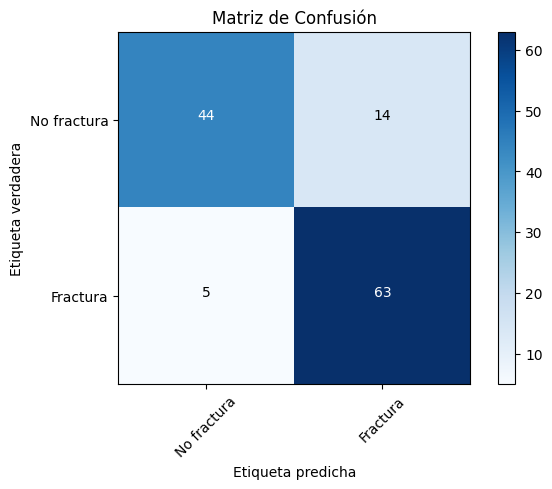

In [ ]:
def plot_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Etiqueta verdadera')
  plt.xlabel('Etiqueta predicha')

cm = confusion_matrix(y_test, y_pred)
plot_matrix(cm, classes=["No fractura", "Fractura"])
plt.show()

## AUC

In [ ]:
# Convertir y_test a enteros
y_test_int = y_test.astype(int)

print(np.bincount(y_test_int))


[58 68]


In [ ]:
y_prob = modelo.predict(X_test).squeeze()  # .squeeze() para eliminar dimensiones de tamaño 1
y_prob


4/4 [==============================] - 5s 1s/step


array([0.5629702 , 0.10827007, 0.91259664, 0.6614746 , 0.02147715,
       0.01326488, 0.5658539 , 0.78769445, 0.56941366, 0.8979161 ,
       0.87440467, 0.54189104, 0.43098897, 0.7443836 , 0.42760304,
       0.92195183, 0.70280945, 0.04611947, 0.8230466 , 0.9443318 ,
       0.90414286, 0.45636782, 0.91915673, 0.09386554, 0.9163154 ,
       0.6263631 , 0.9553223 , 0.48826626, 0.16891974, 0.77243596,
       0.40824685, 0.7864701 , 0.9818482 , 0.8026508 , 0.9655211 ,
       0.10917497, 0.08936974, 0.0637781 , 0.92299896, 0.17617378,
       0.05066107, 0.83823806, 0.8818737 , 0.18589646, 0.5284609 ,
       0.12011988, 0.861747  , 0.1672522 , 0.7591848 , 0.09306148,
       0.19871557, 0.96616626, 0.90617985, 0.85631347, 0.44806612,
       0.8700558 , 0.75273633, 0.13536665, 0.7543023 , 0.8186337 ,
       0.75124353, 0.02176393, 0.93549883, 0.10773991, 0.28556883,
       0.83667046, 0.9526687 , 0.9305919 , 0.11976318, 0.74985427,
       0.5471175 , 0.25242025, 0.69753385, 0.93553865, 0.66029

### Con Librería

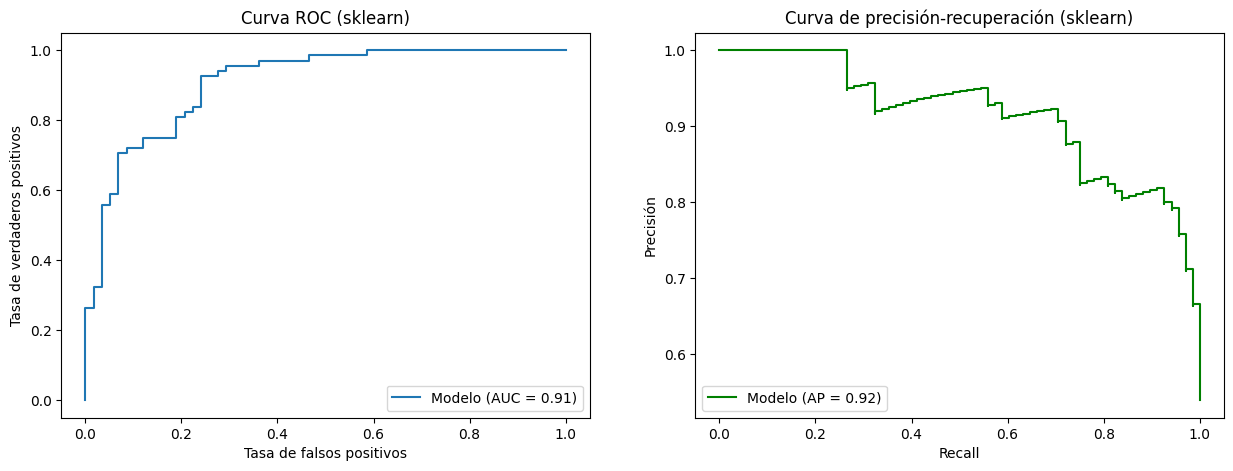

In [ ]:
# y_test es la verdadera etiqueta

auc_roc_lib = roc_auc_score(y_test, y_prob)
auc_pr_lib = average_precision_score(y_test, y_prob)

# Calculando fpr, tpr para la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculando precision, recall para la curva de precisión-recuperación
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graficar AUC-ROC
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Modelo').plot(ax=ax1)
ax1.set_title('Curva ROC (sklearn)')
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.legend(loc='lower right')

# Graficar AUC-PR
PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc, estimator_name='Modelo').plot(ax=ax2, color='green')
ax2.set_title('Curva de precisión-recuperación (sklearn)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precisión')
ax2.legend(loc='lower left')



### Sin Libreria

In [ ]:
def calculate_tpr_fpr(y_true, y_prob, threshold):
    # Predicciones basadas en el umbral
    y_pred = [1 if p >= threshold else 0 for p in y_prob]

    TP = sum([y_true[i] == y_pred[i] == 1 for i in range(len(y_true))])
    FP = sum([y_pred[i] == 1 and y_true[i] == 0 for i in range(len(y_true))])
    FN = sum([y_pred[i] == 0 and y_true[i] == 1 for i in range(len(y_true))])
    TN = sum([y_true[i] == y_pred[i] == 0 for i in range(len(y_true))])

    tpr = TP / (TP + FN) if TP + FN != 0 else 0
    fpr = FP / (FP + TN) if FP + TN != 0 else 0

    return tpr, fpr

def calculate_precision_recall(y_true, y_prob, threshold):
    # Predicciones basadas en el umbral
    y_pred = [1 if p >= threshold else 0 for p in y_prob]

    TP = sum([y_true[i] == y_pred[i] == 1 for i in range(len(y_true))])
    FP = sum([y_pred[i] == 1 and y_true[i] == 0 for i in range(len(y_true))])
    FN = sum([y_pred[i] == 0 and y_true[i] == 1 for i in range(len(y_true))])

    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0

    return precision, recall

def trapezoid_area(x1, x2, y1, y2):
    base = abs(x1 - x2)
    height_avg = (y1 + y2) / 2
    return base * height_avg

In [ ]:
thresholds = np.linspace(0, 1, 1000)

tpr_list = [calculate_tpr_fpr(y_test, y_prob, threshold)[0] for threshold in thresholds]
fpr_list = [calculate_tpr_fpr(y_test, y_prob, threshold)[1] for threshold in thresholds]

# Calcular AUC-ROC
auc_roc = sum([trapezoid_area(fpr_list[i], fpr_list[i+1], tpr_list[i], tpr_list[i+1]) for i in range(len(fpr_list)-1)])

precision_list = [calculate_precision_recall(y_test, y_prob, threshold)[0] for threshold in thresholds]
recall_list = [calculate_precision_recall(y_test, y_prob, threshold)[1] for threshold in thresholds]

while recall_list and recall_list[-1] == 0.0:
    recall_list.pop()
    precision_list.pop()

# Calcular AUC-PR
auc_pr = sum([trapezoid_area(recall_list[i], recall_list[i+1], precision_list[i], precision_list[i+1]) for i in range(len(recall_list)-1)])

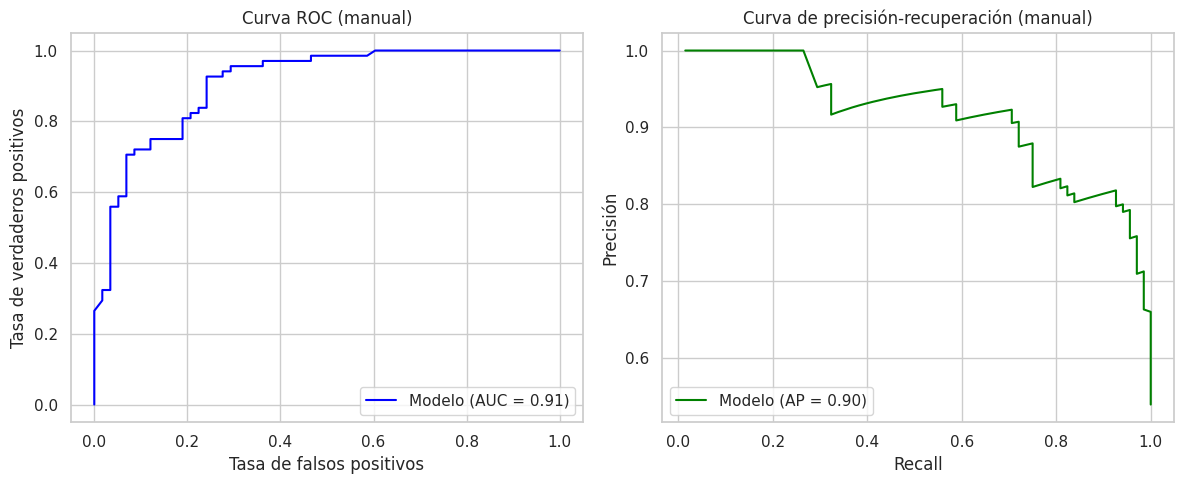

In [ ]:
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
ax1.plot(fpr_list, tpr_list, label=f'Modelo (AUC = {auc_roc:.2f})', color='blue')
ax1.set_title('Curva ROC (manual)')
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall_list, precision_list, label=f'Modelo (AP = {auc_pr:.2f})', color='green')
ax2.set_title('Curva de precisión-recuperación (manual)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precisión')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()


In [ ]:
# Diferencia entre los valores calculados manualmente y los de la librería
error_auc_roc = abs(auc_roc - auc_roc_lib)
error_auc_pr = abs(auc_pr - auc_pr_lib)
print("AUC-ROC (manual):", auc_roc)
print("AUC-PR (manual):", auc_pr)
print()
print("AUC-ROC (sklearn.metrics):", auc_roc_lib)
print("AUC-PR (sklearn.metrics):", auc_pr_lib)
print()
print("Error absoluto en AUC-ROC:", error_auc_roc)
print("Error absoluto en AUC-PR:", error_auc_pr)
print()
print("Error relativo en AUC-ROC:", (error_auc_roc/auc_roc_lib)*100, "%")
print("Error relativo en AUC-PR:", (error_auc_pr/auc_pr_lib)*100, "%")

AUC-ROC (manual): 0.9085953346855986
AUC-PR (manual): 0.9003099249915459

AUC-ROC (sklearn.metrics): 0.9084685598377282
AUC-PR (sklearn.metrics): 0.9151145123737563

Error absoluto en AUC-ROC: 0.00012677484787038118
Error absoluto en AUC-PR: 0.014804587382210355

Error relativo en AUC-ROC: 0.013954786491788539 %
Error relativo en AUC-PR: 1.617785226005003 %


# Gradio Interactivo

## Preprocesamiento

In [ ]:
# Imagenes del dataset
image0 = dataset['train'][200]['image'].save("0.jpg")
image1 = dataset['train'][218]['image'].save("1.jpg")
image3 = dataset['train'][234]['image'].save("2.jpg")
image4 = dataset['train'][213]['image'].save("3.jpg")
image5 = dataset['train'][217]['image'].save("4.jpg")
image6 = dataset['train'][439]['image'].save("5.jpg")
image7 = dataset['train'][487]['image'].save("6.jpg")
image8 = dataset['train'][403]['image'].save("7.jpg")
image8 = dataset['train'][404]['image'].save("8.jpg")
# Otras imagenes

In [ ]:
def preprocess_image3(input_image, target_size=(224, 224)):
    # Comprobar si input_image es una imagen PIL y convertirla a un array NumPy
    if isinstance(input_image, Image.Image):
        image_np = np.array(input_image)
    elif isinstance(input_image, np.ndarray):  # Ya es un array NumPy
        image_np = input_image
    else:
        raise TypeError("El input no es ni una imagen PIL ni un array NumPy.")

    # Convertir a escala de grises si es una imagen a color
    if image_np.ndim == 3:
        image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif image_np.ndim == 2:
        image_gray = image_np
    else:
        raise ValueError("El array de la imagen tiene un número de canales no soportado.")

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_clahe = clahe.apply(image_gray)

    # Redimensionar la imagen en escala de grises
    image_resized = cv2.resize(image_clahe, target_size, interpolation=cv2.INTER_AREA)

    # Normalizar el array de la imagen a [0, 1]
    normalized_image = image_resized / 255.0

    return normalized_image

## Gradiente

### Otsu

In [ ]:
def metodo_otsu(magnitude):
  histogram, bins = np.histogram(magnitude.flatten(), bins=256, range=[0,256])
  bins = bins[0:-1] # bin_edges tiene un elemento más que el array hist

  probabilidades = histogram / np.sum(histogram)
  media_global = np.sum(bins * probabilidades)

  sigma_b_cuadrada_max = 0
  umbral_optimo = 0

  for t in range(len(bins)):
      P1 = np.sum(probabilidades[:t])
      P2 = np.sum(probabilidades[t:])
      if P1 == 0 or P2 == 0:
          continue
      M1 = np.sum(bins[:t] * probabilidades[:t]) / P1
      M2 = np.sum(bins[t:] * probabilidades[t:]) / P2
      sigma_b_cuadrada = P1 * (M1 - media_global)**2 + P2 * (M2 - media_global)**2
      if sigma_b_cuadrada > sigma_b_cuadrada_max:
          sigma_b_cuadrada_max = sigma_b_cuadrada
          umbral_optimo = bins[t]

  return umbral_optimo

### Gradiente

In [ ]:
def sigma_adaptativo(imagen, factor=0.15):
  varianza = np.var(imagen)

  # Calcular sigma como una función logarítmica de la varianza para evitar que sea demasiado grande
  sigma = np.log1p(varianza) * factor

  return sigma

In [ ]:
def central_difference(image):
  # Convertir la imagen a float64 para evitar desbordamiento durante la resta
  image = image.astype(np.float64)

  height, width = image.shape

  Gx = np.zeros((height, width), dtype=np.float64)
  Gy = np.zeros((height, width), dtype=np.float64)

  # Iterar sobre la imagen evitando los bordes
  for i in range(1, height-1):
      for j in range(1, width-1):

        # Diferencias centrales
        Gx[i, j] = (image[i, j+1] - image[i, j-1]) / 2
        Gy[i, j] = (image[i+1, j] - image[i-1, j]) / 2


  return Gx, Gy

In [ ]:
def gradiente3(image):
  gray_image = img_as_ubyte(image)

  Gx, Gy = central_difference(gray_image)

  angle = np.arctan2(Gy, Gx)

  magnitud = np.sqrt(Gx**2 + Gy**2)

  T =  metodo_otsu(magnitud)

  binary_image = (magnitud > T).astype(np.uint8) * 255

  # Normalizar la magnitud para la visualización
  normalized_magnitud = (magnitud / magnitud.max()) * 255
  normalized_magnitud = normalized_magnitud.astype(np.uint8)

  # Angulo visual
  angle_degrees = np.degrees(angle)
  angle_normalized = (angle_degrees + 180) / 360  # Normalizar los ángulos entre 0 y 1
  angle_for_display = (angle_normalized * 255).astype(np.uint8)  # Escalar para el rango de 8 bits

  # Aplicar filtro gaussiano para suavizado
  sigma = sigma_adaptativo(image)
  radiografia_suavizada = gaussian_filter(image, sigma=sigma)

  binarizado_gradiente = magnitud > T

  # Restar la imagen binarizada de bordes de la radiografía suavizada
  bordes_resaltados = radiografia_suavizada - binarizado_gradiente

  return Gx, Gy, normalized_magnitud, binary_image, bordes_resaltados

## Predicción

In [ ]:
def predict_fracture3(model, image):
    # Preprocesamiento de la imagen
    image_processed = preprocess_image3(image)
    image_processed_2d = np.squeeze(image_processed)  # Guardar versión de 2 dimensiones

    # Expandir las dimensiones para la predicción del modelo
    image_for_model = np.expand_dims(image_processed, axis=0)
    image_for_model = np.expand_dims(image_for_model, axis=-1)

    prediction = modelo.predict(image_for_model)

    no_identificado = 0
    # Probabilidad de fractura
    probability_of_fracture = prediction[0][0]
    if (abs((1 - probability_of_fracture)-probability_of_fracture) <= 0.25):
      no_identificado = 1

    response = {
        'No Fractura':  1 - probability_of_fracture,
        'Fractura': probability_of_fracture,
        'No identificado': no_identificado
    }


    Gx, Gy, magnitud, binary_image, bordes_resaltados = gradiente3(image_processed_2d)

    def to_uint8(img):
        img_normalized = (img - img.min()) / (img.max() - img.min())
        # Escalar y convertir a uint8
        return (255 * img_normalized).astype(np.uint8)


    # Convertir a formato de imagen para mostrar en Gradio
    output_images = [
        Image.fromarray(to_uint8(image_processed_2d), mode="L"),
        Image.fromarray(to_uint8(Gx), mode="L"),
        Image.fromarray(to_uint8(Gy), mode="L"),
        Image.fromarray(to_uint8(magnitud), mode="L"),
        Image.fromarray(to_uint8(binary_image), mode="L"),
        Image.fromarray(to_uint8(bordes_resaltados), mode="L")
    ]

    return [response] + output_images



---


# Interactivo



---



In [ ]:
# Gradio interfaz
interface = gr.Interface(
    fn=lambda image: predict_fracture3(modelo, image),
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(num_top_classes=3)] + [gr.Image(type="pil") for _ in range(6)],
    examples=["0.jpg", "1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg", "6.jpg", "7.jpg", "8.jpg"],
    live=False
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://11f233698db5f42c61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
